In [1]:
import os
import glob
import pandas as pd

DATA_DIR = "/home/tushar/cadica/CADICA"
SELECTED_FOLDER = "selectedVideos"
base_dir = os.path.join(DATA_DIR, SELECTED_FOLDER)

SEVERITY_MAP = {'p0': 0, 'p0_20': 1, 'p20_50': 2, 'p50_70': 3}
CLASS_NAMES = ['none', 'mild', 'moderate', 'severe']

rows = []

for patient_dir in glob.glob(os.path.join(base_dir, 'p*')):
    for video_dir in glob.glob(os.path.join(patient_dir, 'v*')):
        input_dir = os.path.join(video_dir, 'input')
        gt_dir = os.path.join(video_dir, 'groundtruth')
        selected_frames_file = os.path.join(
            video_dir,
            f"{os.path.basename(patient_dir)}_{os.path.basename(video_dir)}_selectedFrames.txt"
        )
        if not os.path.exists(selected_frames_file):
            continue
        with open(selected_frames_file) as f:
            selected_frames = set(line.strip() for line in f if line.strip())
        for frame_id in selected_frames:
            frame_path = os.path.join(input_dir, frame_id + ".png")
            gt_file = os.path.join(gt_dir, f"{frame_id}.txt")
            if not os.path.exists(frame_path):
                continue
            rel_image_path = os.path.relpath(frame_path, base_dir)  # e.g. p01/v01/input/frame_001.png
            rel_image_id = os.path.splitext(rel_image_path)[0]      # e.g. p01/v01/input/frame_001
            if os.path.exists(gt_file):
                with open(gt_file) as f:
                    lines = [l.strip() for l in f if l.strip()]
                for l in lines:
                    parts = l.split()
                    x, y, w, h = map(int, parts[:4])
                    sev = parts[4]
                    if sev not in SEVERITY_MAP:
                        continue
                    class_id = SEVERITY_MAP[sev]
                    class_name = CLASS_NAMES[class_id]
                    x_min, y_min, x_max, y_max = x, y, x + w, y + h
                    rows.append({
                        "image_id": rel_image_id,
                        "class_name": class_name,
                        "class_id": class_id,
                        "x_min": x_min,
                        "y_min": y_min,
                        "x_max": x_max,
                        "y_max": y_max
                    })

df = pd.DataFrame(rows)


In [ ]:
# from sklearn.model_selection import train_test_split

# unique_image_ids = df['image_id'].unique()
# train_ids, test_ids = train_test_split(unique_image_ids, test_size=0.3, random_state=42)

# train_df = df[df['image_id'].isin(train_ids)].reset_index(drop=True)
# test_df = df[df['image_id'].isin(test_ids)].reset_index(drop=True)

# train_df.to_csv("/home/tushar/train.csv", index=False)
# test_df.to_csv("/home/tushar/test.csv", index=False)

In [2]:
import pandas as pd
import numpy as np
import cv2
import os

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision
from torchvision.ops import box_iou, MultiScaleRoIAlign
from torchvision import models

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from torch.utils.data import DataLoader, Dataset
import pytorch_lightning as pl

SEED=2484
DEVICE=torch.device('cuda')
pl.utilities.seed.seed_everything(SEED)

/home/tushar/anaconda3/envs/clone/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/tushar/anaconda3/envs/clone/lib/python3.9/site-packages/pytorch_lightning/utilities/imports.py:23: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Global seed set to 2484


2484

In [3]:
class VBDDataset(Dataset):
    def __init__(self, dataframe, image_dir, transforms=None, phase='train'):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        self.phase = phase

    # def __getitem__(self, idx):

    #     image_id = self.image_ids[idx]
    #     records = self.df[self.df['image_id'] == image_id]
        

    #     image = cv2.imread(f'{self.image_dir}/{image_id}.png', cv2.IMREAD_COLOR)
    #     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    #     image /= 255.0

    #     if self.phase == 'test':
    #         if self.transforms:
    #             sample = {
    #                 'image': image,
    #             }
    #             sample = self.transforms(**sample)
    #             image = sample['image']
    #         return image, image_id

    #     boxes = records[['x_min', 'y_min', 'x_max', 'y_max']].values
        
    #     area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    #     area = torch.as_tensor(area, dtype=torch.float32)
    #     # all the labels are shifted by 1 to accomodate background
    #     labels = torch.squeeze(torch.as_tensor((records.class_id.values+1,), dtype=torch.int64))
    #     iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
    #     target = {}
    #     target['boxes'] = boxes
    #     target['labels'] = labels
    #     target['area'] = area
    #     target['image_id'] = torch.tensor([idx])
    #     target['iscrowd'] = iscrowd
    #     if self.transforms:
    #         sample = {
    #             'image': image,
    #             'bboxes': target['boxes'],
    #             'labels': labels
    #         }
    #         sample = self.transforms(**sample)
    #         image = sample['image']
            
    #         target['boxes'] = torch.as_tensor(sample['bboxes'])

    #     return image, target
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.png', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        if self.phase == 'test':
            if self.transforms:
                sample = {'image': image}
                sample = self.transforms(**sample)
                image = sample['image']
            return image, image_id

        # --- Prepare boxes and labels as numpy arrays ---
        boxes = records[['x_min', 'y_min', 'x_max', 'y_max']].values.astype(np.float32)  # shape (N, 4)
        labels = records.class_id.values.astype(np.int64)                                # shape (N,)

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)

        target = {
            'boxes': torch.as_tensor(boxes, dtype=torch.float32),
            'labels': torch.as_tensor(labels, dtype=torch.int64),
            'area': area,
            'image_id': torch.tensor([idx]),
            'iscrowd': iscrowd
        }

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': boxes,      # numpy array, shape (N, 4)
                'labels': labels      # numpy array, shape (N,)
            }
            sample = self.transforms(**sample)
            image = sample['image']
            # Convert back to torch tensors
            target['boxes'] = torch.as_tensor(sample['bboxes'], dtype=torch.float32)
            target['labels'] = torch.as_tensor(sample['labels'], dtype=torch.int64)

        return image, target

    def __len__(self):
        return self.image_ids.shape[0]

In [4]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

def get_train_transform():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        # Optionally: A.VerticalFlip(p=0.5),
        ToTensorV2(p=1.0)
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))
def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ])




def collate_fn(batch):
    return tuple(zip(*batch))

def format_prediction_string(labels, boxes, scores):
    pred_strings = []
    for j in zip(labels, scores, boxes):
        pred_strings.append("{0} {1:.4f} {2} {3} {4} {5}".format(
            j[0], j[1], j[2][0], j[2][1], j[2][2], j[2][3]))
    return " ".join(pred_strings)

In [5]:
class VinDetector(pl.LightningModule):
    def __init__(self, **kwargs):
        super().__init__()

        self.model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
        num_classes = 15
        in_features = self.model.roi_heads.box_predictor.cls_score.in_features
        self.model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        self.learning_rate = 1e-3
        self.batch_size = 4

    def forward(self, x):
        return self.model(x)

    def prepare_data(self):
        df = pd.read_csv('/home/tushar/train.csv')
        df = df[df['class_id'] != 4].reset_index(drop=True)
        self.train_dataset = VBDDataset(df, "/home/tushar/cadica/CADICA/selectedVideos", get_train_transform())

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, pin_memory=True, num_workers=4, collate_fn=collate_fn)

    def training_step(self, batch, batch_idx):
        images, targets = batch
        targets = [{k: v for k, v in t.items()} for t in targets]
        loss_dict = self.model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        self.log('Loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        return {"loss": loss}

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.model.parameters(), lr=self.learning_rate, momentum=0.95, weight_decay=1e-5, nesterov=True)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=6, eta_min=0, verbose=True)
        return [optimizer], [scheduler]

In [6]:
df.head()

image_id class_name  class_id  x_min  y_min  x_max  y_max
0  p15/v3/input/p15_v3_00023     severe         3    210    117    232    149
1  p15/v3/input/p15_v3_00015     severe         3    207     93    237    127
2  p15/v3/input/p15_v3_00014     severe         3    231     97    260    133
3  p15/v3/input/p15_v3_00020     severe         3    227    112    246    145
4  p15/v3/input/p15_v3_00024     severe         3    183    104    211    129

In [8]:
net = VinDetector()
trainer = pl.Trainer(max_epochs=15, gpus=1, progress_bar_refresh_rate=100)
trainer.fit(net)

/home/tushar/anaconda3/envs/clone/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/tushar/anaconda3/envs/clone/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/tushar/anaconda3/envs/clone/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:90: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=100)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 0:   0%|          | 0/537 [00:00<?, ?it/s] 

/home/tushar/anaconda3/envs/clone/lib/python3.9/site-packages/pytorch_lightning/utilities/data.py:56: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Epoch 14: 100%|██████████| 537/537 [03:51<00:00,  2.32it/s, loss=0.112, v_num=155, Loss_step=0.164, Loss_epoch=0.125] 


In [9]:
for p in net.model.parameters():
    p.requires_grad = True

trainer = pl.Trainer(max_epochs=15, gpus=1, progress_bar_refresh_rate=50, precision=16)
trainer.fit(net)

Using 16bit native Automatic Mixed Precision (AMP)
/home/tushar/anaconda3/envs/clone/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:90: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=50)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name  | Type       | Params
-------------------------------------
0 | model | FasterRCNN | 41.4 M
-------------------------------------
41.4 M    Trainable params
0         Non-trainable params
41.4 M    Total params
82.732    Total estimated model params size (MB)


Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 14: 100%|██████████| 537/537 [03:44<00:00,  2.39it/s, loss=0.0682, v_num=156, Loss_step=0.0512, Loss_epoch=0.0843]


In [16]:
df = pd.read_csv('/home/tushar/test.csv')
test_dataset = VBDDataset(df, "/home/tushar/cadica/CADICA/selectedVideos", get_valid_transform(), phase='test')
test_data_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4, collate_fn=collate_fn)

In [39]:
# To see all parameter names and shapes
for name, param in net.model.state_dict().items():
    print(name, param.shape)

# To access a specific layer's weights, e.g., the classifier's final layer
print(net.model.roi_heads.box_predictor.cls_score.weight)
print(net.model.roi_heads.box_predictor.cls_score.bias)


backbone.body.conv1.weight torch.Size([64, 3, 7, 7])
backbone.body.bn1.weight torch.Size([64])
backbone.body.bn1.bias torch.Size([64])
backbone.body.bn1.running_mean torch.Size([64])
backbone.body.bn1.running_var torch.Size([64])
backbone.body.layer1.0.conv1.weight torch.Size([64, 64, 1, 1])
backbone.body.layer1.0.bn1.weight torch.Size([64])
backbone.body.layer1.0.bn1.bias torch.Size([64])
backbone.body.layer1.0.bn1.running_mean torch.Size([64])
backbone.body.layer1.0.bn1.running_var torch.Size([64])
backbone.body.layer1.0.conv2.weight torch.Size([64, 64, 3, 3])
backbone.body.layer1.0.bn2.weight torch.Size([64])
backbone.body.layer1.0.bn2.bias torch.Size([64])
backbone.body.layer1.0.bn2.running_mean torch.Size([64])
backbone.body.layer1.0.bn2.running_var torch.Size([64])
backbone.body.layer1.0.conv3.weight torch.Size([256, 64, 1, 1])
backbone.body.layer1.0.bn3.weight torch.Size([256])
backbone.body.layer1.0.bn3.bias torch.Size([256])
backbone.body.layer1.0.bn3.running_mean torch.Size([

In [17]:
detection_threshold = 0.5
results = []
net.model.to(DEVICE)
net.model.eval()

with torch.no_grad():
    for images, image_ids in test_data_loader:
        images = list(image.to(DEVICE) for image in images)
        outputs = net.model(images)
        for i, image in enumerate(images):
            image_id = image_ids[i]
            result = {
                'image_id': image_id,
                'PredictionString': '1 1.0 0 0 1 1'
            }
            boxes = outputs[i]['boxes'].data.cpu().numpy()
            labels = outputs[i]['labels'].data.cpu().numpy()
            scores = outputs[i]['scores'].data.cpu().numpy()
            if len(boxes) > 0:
                labels = labels 
                labels[labels == -1] = 14
                selected = scores >= detection_threshold
                boxes = boxes[selected].astype(np.int32)
                scores = scores[selected]
                labels = labels[selected]
                if len(boxes) > 0:
                    result = {
                        'image_id': image_id,
                        'PredictionString': format_prediction_string(labels, boxes, scores)
                    }
            results.append(result)

In [18]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.head()

image_id          PredictionString
0  p15/v3/input/p15_v3_00023  3 0.6389 209 118 231 152
1  p15/v3/input/p15_v3_00026   3 0.9617 140 77 171 104
2  p15/v3/input/p15_v3_00024  3 0.9669 180 108 209 140
3  p15/v3/input/p15_v3_00025  3 0.9984 179 100 209 131
4  p15/v4/input/p15_v4_00033  3 0.9866 267 102 317 123

In [19]:
def parse_prediction_string(pred_str):
    if not isinstance(pred_str, str) or pred_str.strip() == "":
        return [], [], []
    parts = pred_str.strip().split()
    labels = []
    scores = []
    boxes = []
    for i in range(0, len(parts), 6):
        label = int(parts[i])
        score = float(parts[i+1])
        box = [int(parts[i+2]), int(parts[i+3]), int(parts[i+4]), int(parts[i+5])]
        labels.append(label)
        scores.append(score)
        boxes.append(box)
    return labels, scores, boxes


In [27]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd

def visualize_prediction(image_dir, image_id, gt_df, pred_df, score_thresh=0.5):
    # Load image
    img_path = f"{image_dir}/{image_id}.png"
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_pred = image.copy()
    img_gt = image.copy()

    # Draw ground truth boxes (in green)
    gt_boxes = gt_df[gt_df['image_id'] == image_id]
    for _, row in gt_boxes.iterrows():
        x1, y1, x2, y2 = int(row['x_min']), int(row['y_min']), int(row['x_max']), int(row['y_max'])
        cv2.rectangle(img_gt, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img_gt, str(row['class_id']), (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)

    # Draw predicted boxes (in red)
    pred_row = pred_df[pred_df['image_id'] == image_id]
    if not pred_row.empty:
        labels, scores, boxes = parse_prediction_string(pred_row.iloc[0]['PredictionString'])
        for label, score, box in zip(labels, scores, boxes):
            if score < score_thresh:
                continue
            x1, y1, x2, y2 = box
            cv2.rectangle(img_pred, (x1, y1), (x2, y2), (255, 0, 0), 2)
            cv2.putText(img_pred, f"{label}:{score:.2f}", (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)

    # Plot side by side
    plt.figure(figsize=(14,7))
    plt.subplot(1,2,1)
    plt.title("Ground Truth")
    plt.imshow(img_gt)
    plt.axis('off')
    
    plt.subplot(1,2,2)
    plt.title("Predictions")
    plt.imshow(img_pred)
    plt.axis('off')
    plt.show()


In [32]:
import numpy as np

def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea + 1e-6)
    return iou

def evaluate_od(gt_df, pred_df, iou_threshold=0.5, score_threshold=0.5, num_classes=4):
    # Store per-class stats for AP
    stats = {c: {'tp': [], 'fp': [], 'scores': [], 'n_gt': 0, 'ious': []} for c in range(num_classes)}

    for image_id in gt_df['image_id'].unique():
        gt_boxes = gt_df[gt_df['image_id'] == image_id]
        pred_row = pred_df[pred_df['image_id'] == image_id]
        if not pred_row.empty:
            labels, scores, boxes = parse_prediction_string(pred_row.iloc[0]['PredictionString'])
            filtered = [(l, s, b) for l, s, b in zip(labels, scores, boxes) if s >= score_threshold]
        else:
            filtered = []

        for class_id in range(num_classes):
            gt_cls_boxes = gt_boxes[gt_boxes['class_id'] == class_id][['x_min','y_min','x_max','y_max']].values
            pred_cls = [(s, b) for l, s, b in filtered if l == class_id]
            pred_cls = sorted(pred_cls, key=lambda x: -x[0])  # sort by score descending
            n_gt = len(gt_cls_boxes)
            stats[class_id]['n_gt'] += n_gt
            matched = np.zeros(n_gt, dtype=bool)
            for score, pred_box in pred_cls:
                ious = [compute_iou(pred_box, gt_box) for gt_box in gt_cls_boxes]
                if ious and max(ious) >= iou_threshold:
                    idx = np.argmax(ious)
                    if not matched[idx]:
                        stats[class_id]['tp'].append(1)
                        stats[class_id]['fp'].append(0)
                        stats[class_id]['ious'].append(ious[idx])
                        matched[idx] = True
                    else:
                        stats[class_id]['tp'].append(0)
                        stats[class_id]['fp'].append(1)
                        stats[class_id]['ious'].append(0)
                else:
                    stats[class_id]['tp'].append(0)
                    stats[class_id]['fp'].append(1)
                    stats[class_id]['ious'].append(0)
                stats[class_id]['scores'].append(score)

    # Compute metrics
    per_class_precision = []
    per_class_recall = []
    per_class_f1 = []
    per_class_ap = []
    per_class_iou = []
    for c in range(num_classes):
        tp = np.array(stats[c]['tp'])
        fp = np.array(stats[c]['fp'])
        scores = np.array(stats[c]['scores'])
        n_gt = stats[c]['n_gt']
        ious = np.array(stats[c]['ious'])
        if len(tp) == 0:
            per_class_precision.append(0)
            per_class_recall.append(0)
            per_class_f1.append(0)
            per_class_ap.append(0)
            per_class_iou.append(0)
            continue
        # Precision, Recall, F1
        cum_tp = np.cumsum(tp)
        cum_fp = np.cumsum(fp)
        precision = cum_tp / (cum_tp + cum_fp + 1e-6)
        recall = cum_tp / (n_gt + 1e-6)
        f1 = 2 * precision * recall / (precision + recall + 1e-6)
        per_class_precision.append(precision[-1] if len(precision) > 0 else 0)
        per_class_recall.append(recall[-1] if len(recall) > 0 else 0)
        per_class_f1.append(f1[-1] if len(f1) > 0 else 0)
        # AP (11-point interpolation)
        ap = 0
        for t in np.linspace(0, 1, 11):
            p = precision[recall >= t]
            ap += np.max(p) if np.any(p) else 0
        ap /= 11
        per_class_ap.append(ap)
        per_class_iou.append(np.mean(ious[tp == 1]) if np.any(tp == 1) else 0)

    mAP = np.mean(per_class_ap)
    mean_iou = np.mean([iou for iou in per_class_iou if iou > 0]) if any(per_class_iou) else 0

    return {
        'per_class_precision': per_class_precision,
        'per_class_recall': per_class_recall,
        'per_class_f1': per_class_f1,
        'per_class_ap': per_class_ap,
        'per_class_iou': per_class_iou,
        'mAP': mAP,
        'mean_iou': mean_iou
    }


In [33]:
metrics = evaluate_od(gt_df, test_df, iou_threshold=0.5, score_threshold=0.5, num_classes=4)
print("Per-class Precision:", metrics['per_class_precision'])
print("Per-class Recall:", metrics['per_class_recall'])
print("Per-class F1:", metrics['per_class_f1'])
print("Per-class AP:", metrics['per_class_ap'])
print("Per-class IoU:", metrics['per_class_iou'])
print("mAP:", metrics['mAP'])
print("Mean IoU:", metrics['mean_iou'])


Per-class Precision: [0, 0.7721518976481689, 0.7972972946037253, 0.8539682512572436]
Per-class Recall: [0, 0.8840579695908889, 0.8027210857050303, 0.8819672102230584]
Per-class F1: [0, 0.8243238253695887, 0.7999994972941936, 0.8677414328150642]
Per-class AP: [0, 0.6524961018371648, 0.7106120599811407, 0.740021849234083]
Per-class IoU: [0, 0.7806307428374288, 0.7647322939393428, 0.785891675146575]
mAP: 0.5257825027630971
Mean IoU: 0.7770849039744488


In [3]:
per_class_precision =  [ 0.7721518976481689, 0.7972972946037253, 0.8539682512572436]
per_class_recall    = [ 0.8840579695908889, 0.8027210857050303, 0.8819672102230584]
per_class_f1        = [ 0.8243238253695887, 0.7999994972941936, 0.8677414328150642]
per_class_ap        = [0.6524961018371648, 0.7106120599811407, 0.740021849234083]

mean_precision = np.mean(per_class_precision)
mean_recall    = np.mean(per_class_recall)
mean_f1        = np.mean(per_class_f1)
mean_ap        = np.mean(per_class_ap)  # mAP

print(f"Mean Precision: {mean_precision:.4f}")
print(f"Mean Recall:    {mean_recall:.4f}")
print(f"Mean F1:        {mean_f1:.4f}")
print(f"Mean AP (mAP):  {mean_ap:.4f}")



Mean Precision: 0.8078
Mean Recall:    0.8562
Mean F1:        0.8307
Mean AP (mAP):  0.7010


In [21]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd

def visualize_prediction(image_dir, image_id, gt_df, pred_df, score_thresh=0.5):
    # Load image
    img_path = f"{image_dir}/{image_id}.png"
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_pred = image.copy()
    img_gt = image.copy()

    # Draw ground truth boxes (in green)
    gt_boxes = gt_df[gt_df['image_id'] == image_id]
    for _, row in gt_boxes.iterrows():
        x1, y1, x2, y2 = int(row['x_min']), int(row['y_min']), int(row['x_max']), int(row['y_max'])
        cv2.rectangle(img_gt, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img_gt, str(row['class_id']), (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)

    # Draw predicted boxes (in red)
    pred_row = pred_df[pred_df['image_id'] == image_id]
    if not pred_row.empty:
        labels, scores, boxes = parse_prediction_string(pred_row.iloc[0]['PredictionString'])
        for label, score, box in zip(labels, scores, boxes):
            if score < score_thresh:
                continue
            x1, y1, x2, y2 = box
            cv2.rectangle(img_pred, (x1, y1), (x2, y2), (255, 0, 0), 2)
            cv2.putText(img_pred, f"{label}:{score:.2f}", (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)

    # Plot side by side
    plt.figure(figsize=(14,7))
    plt.subplot(1,2,1)
    plt.title("Ground Truth")
    plt.imshow(img_gt)
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.title("Predictions")
    plt.imshow(img_pred)
    plt.axis('off')
    plt.show()


# 30 epochs

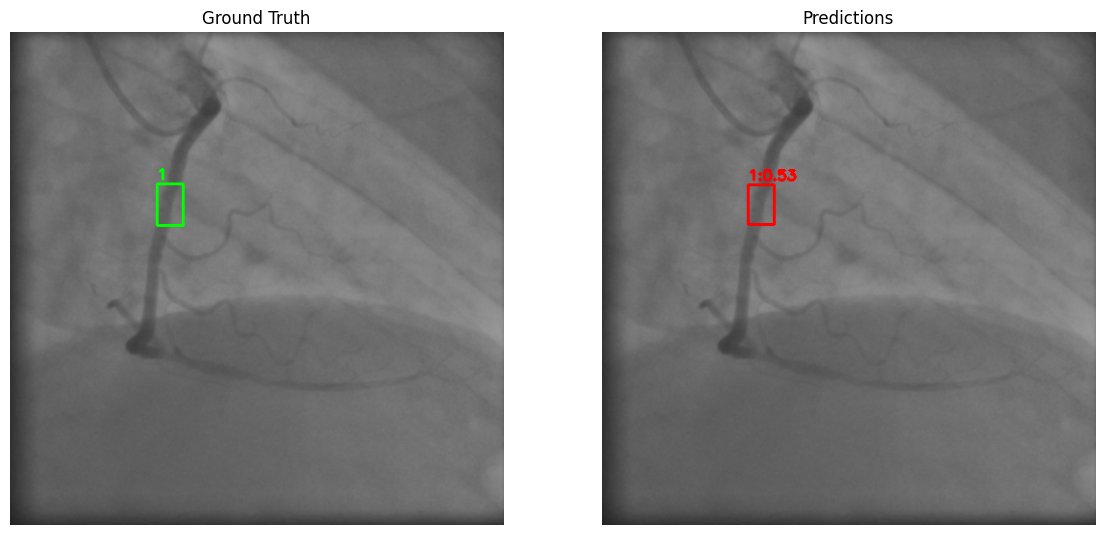

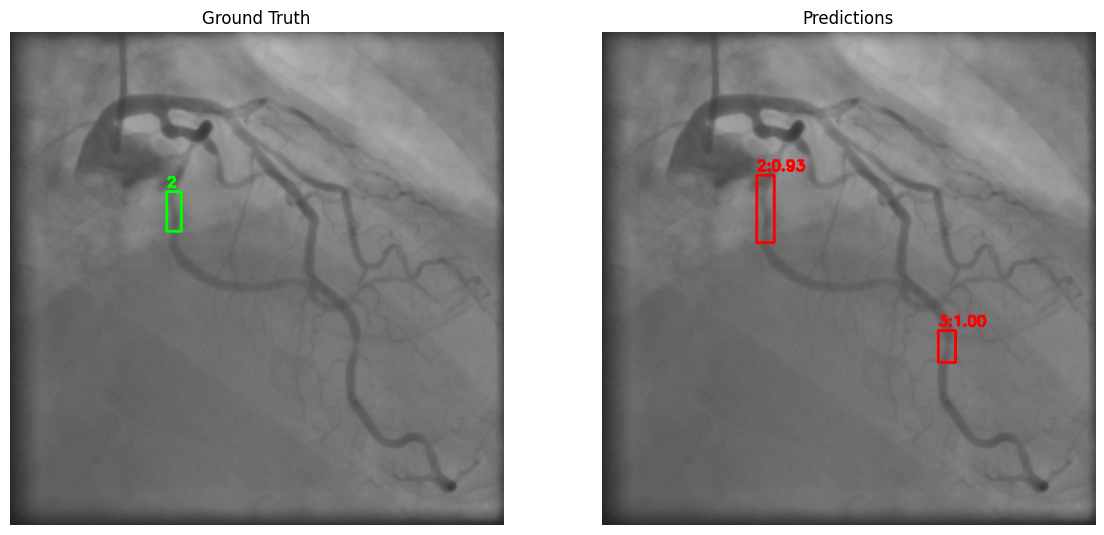

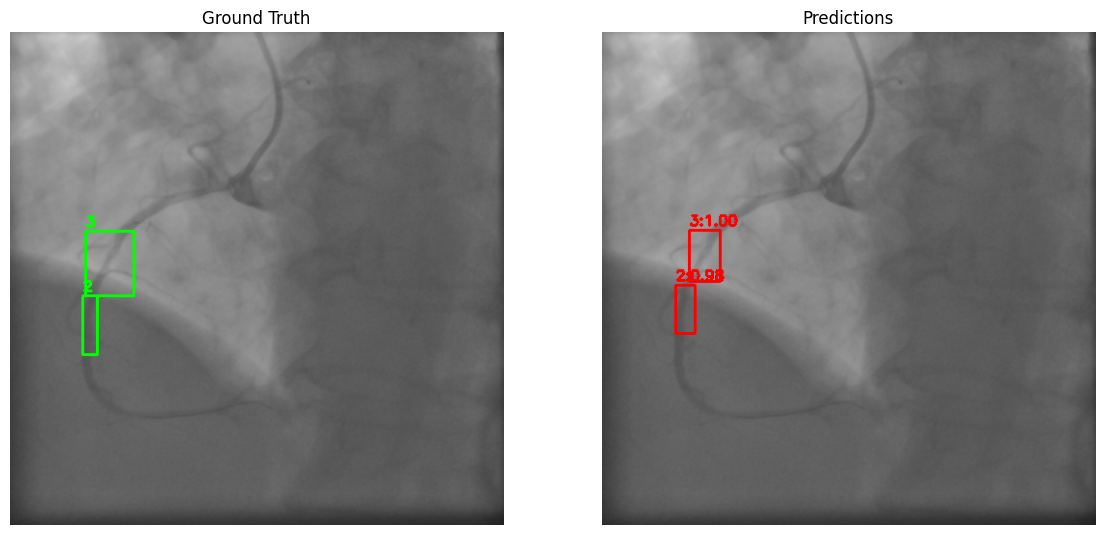

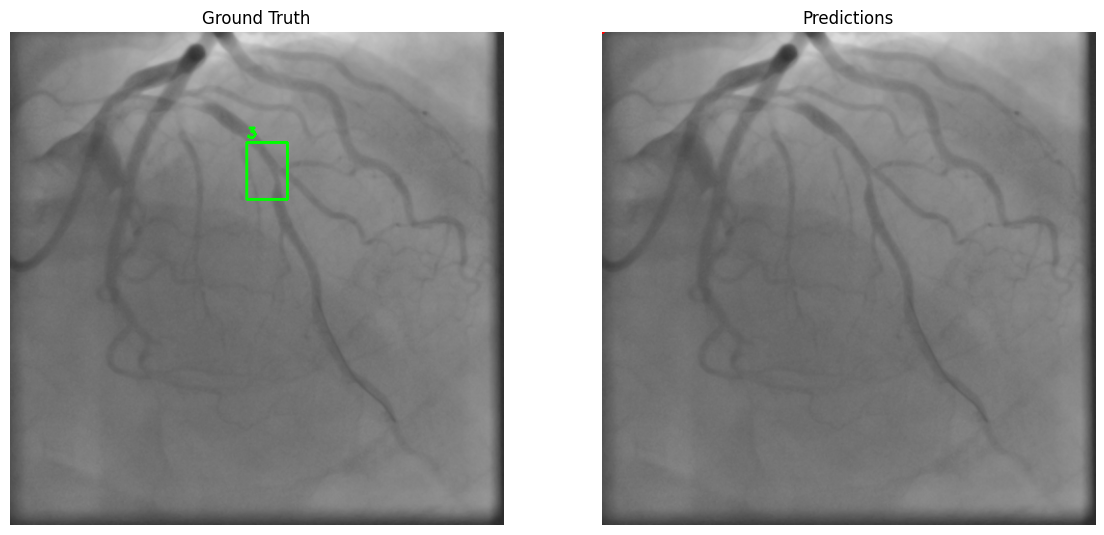

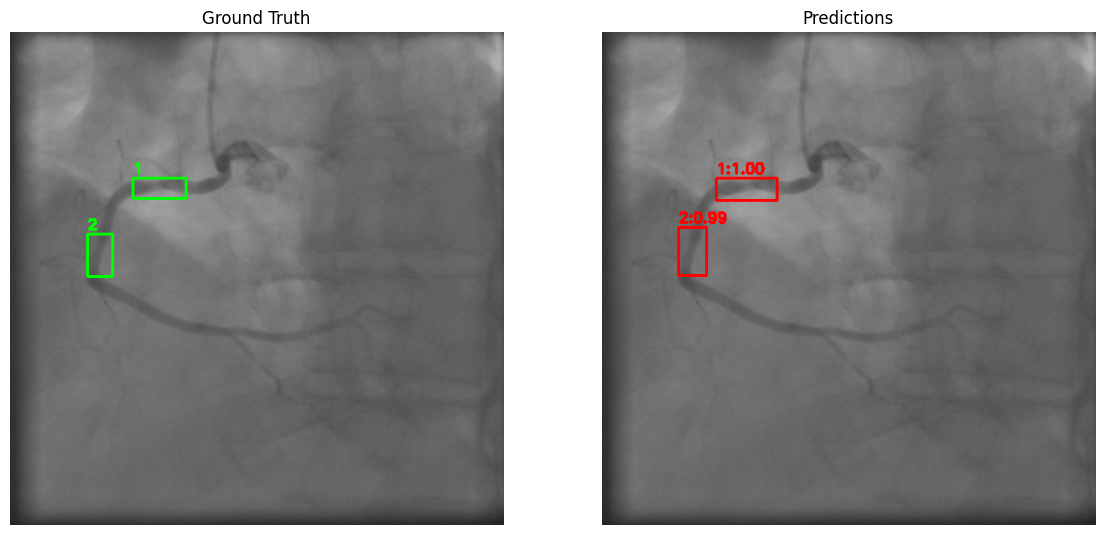

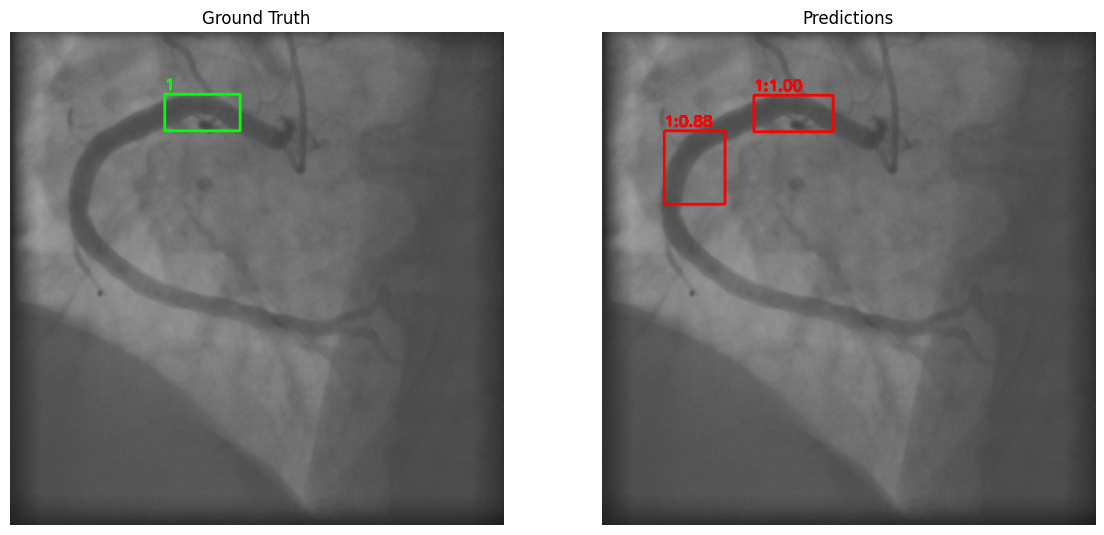

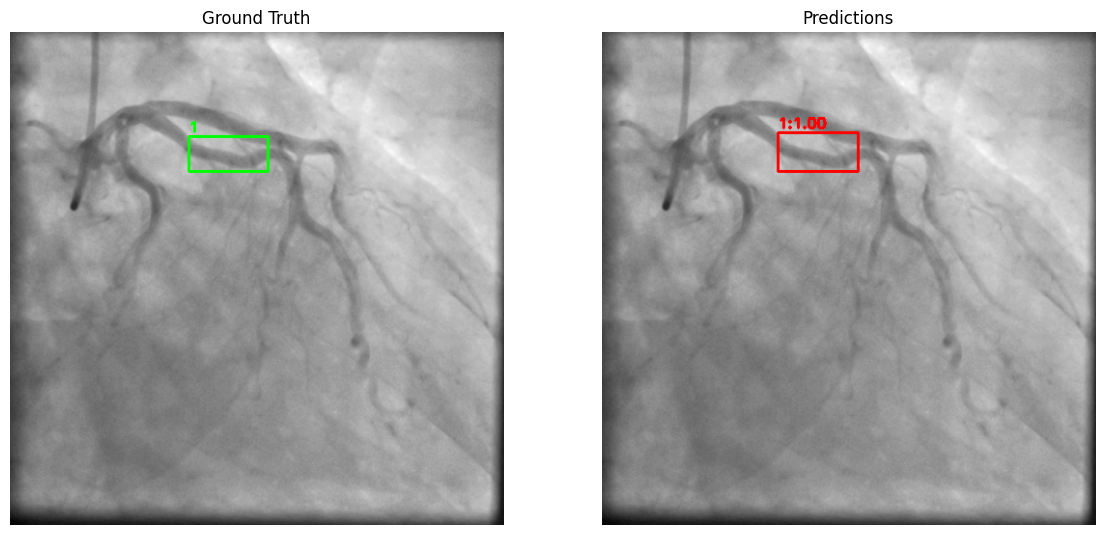

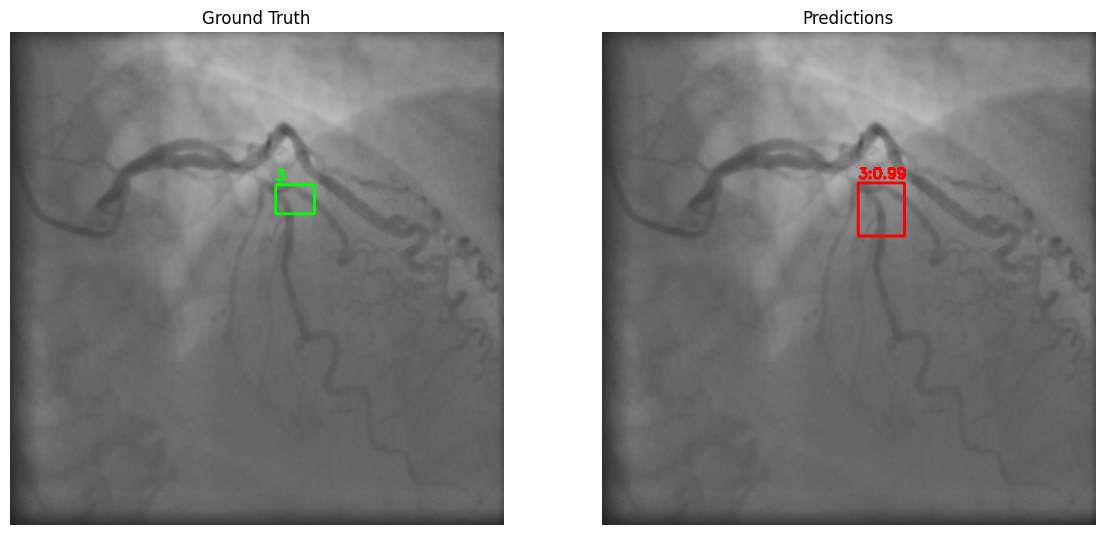

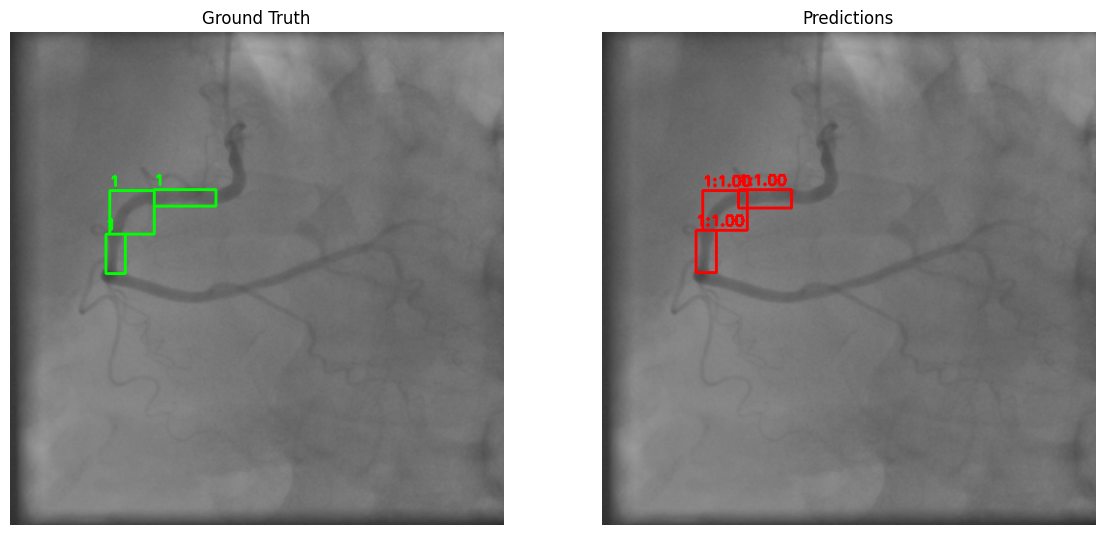

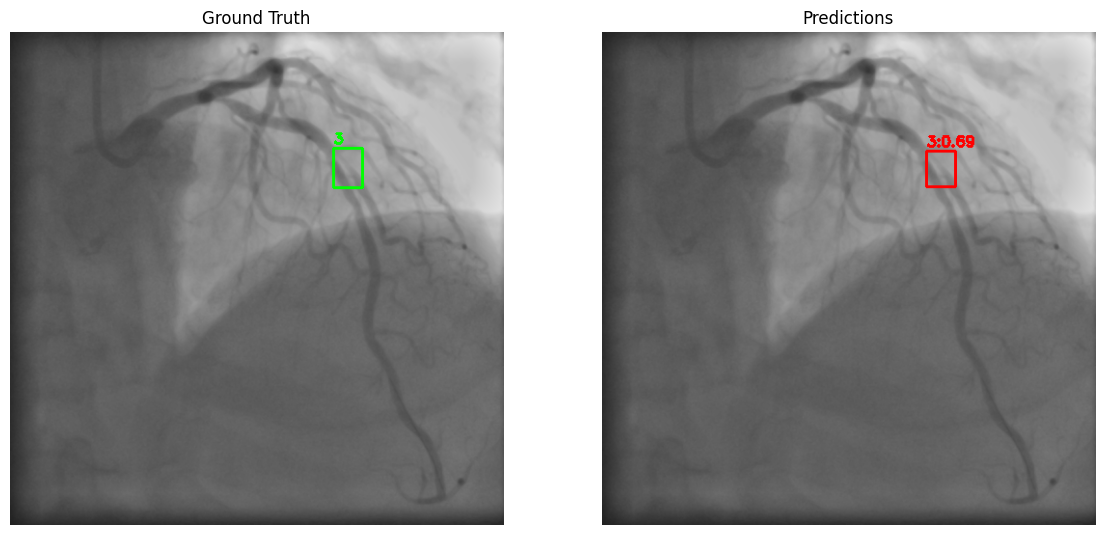

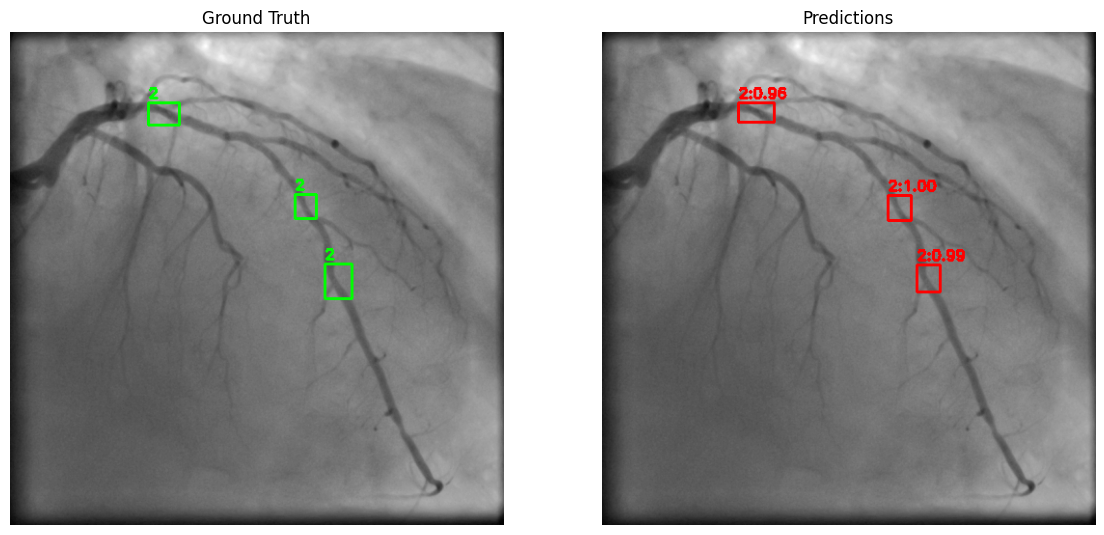

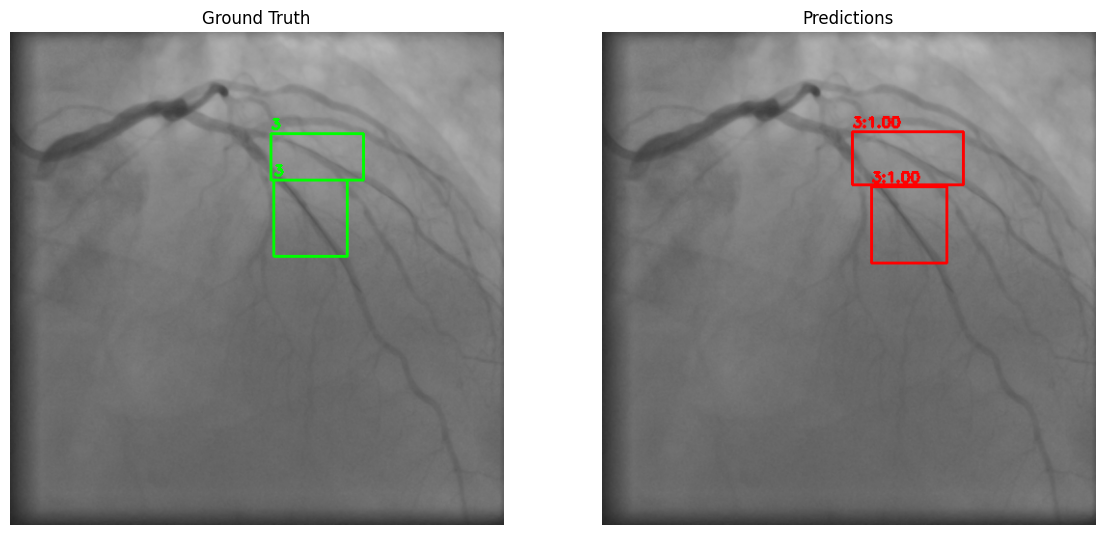

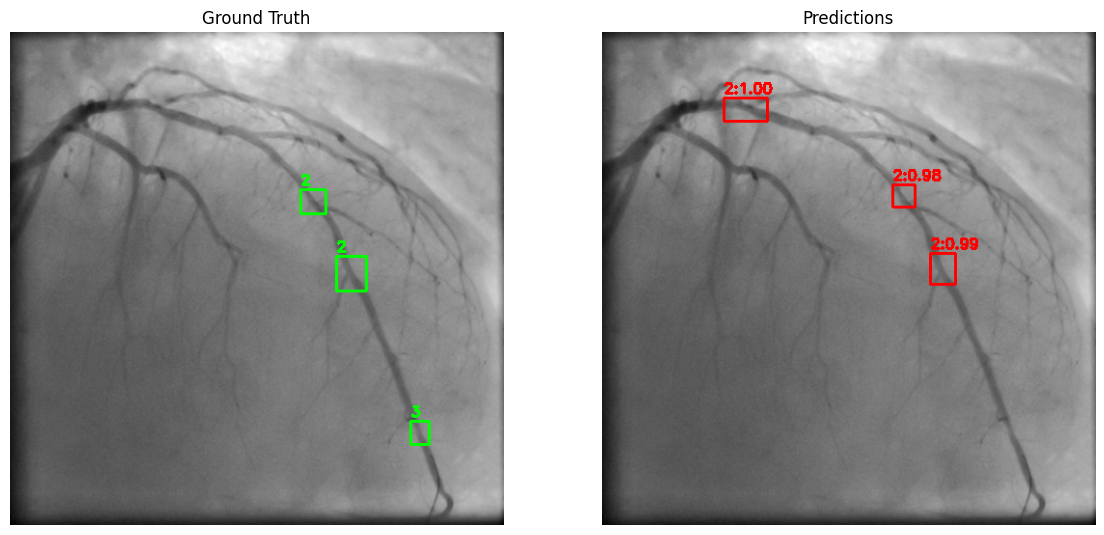

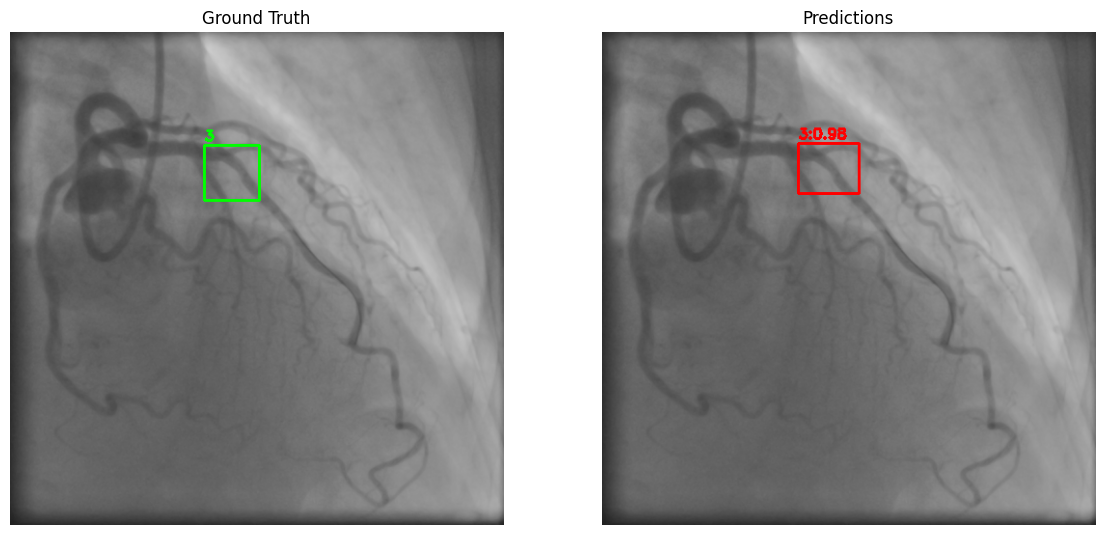

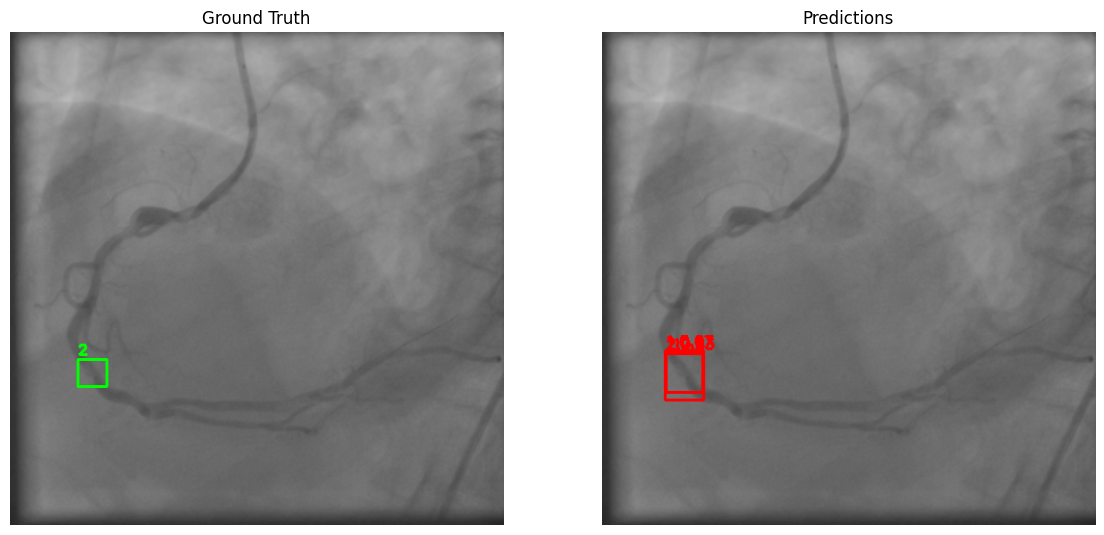

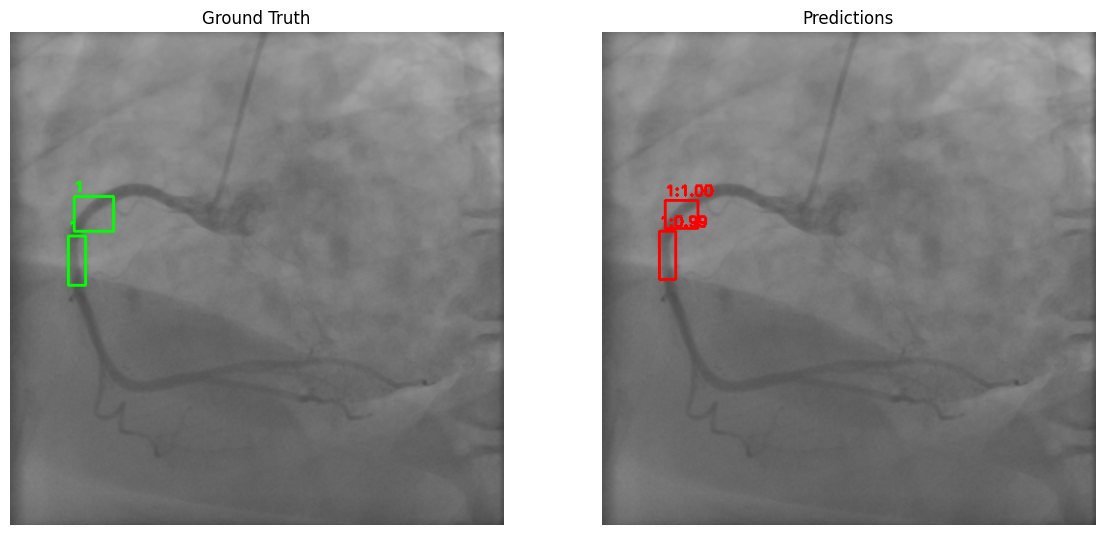

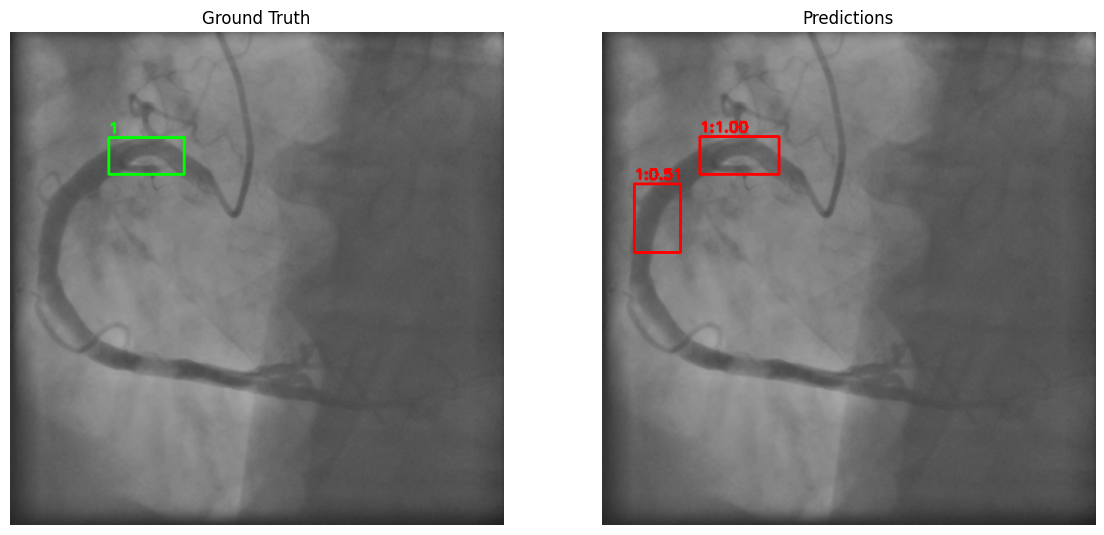

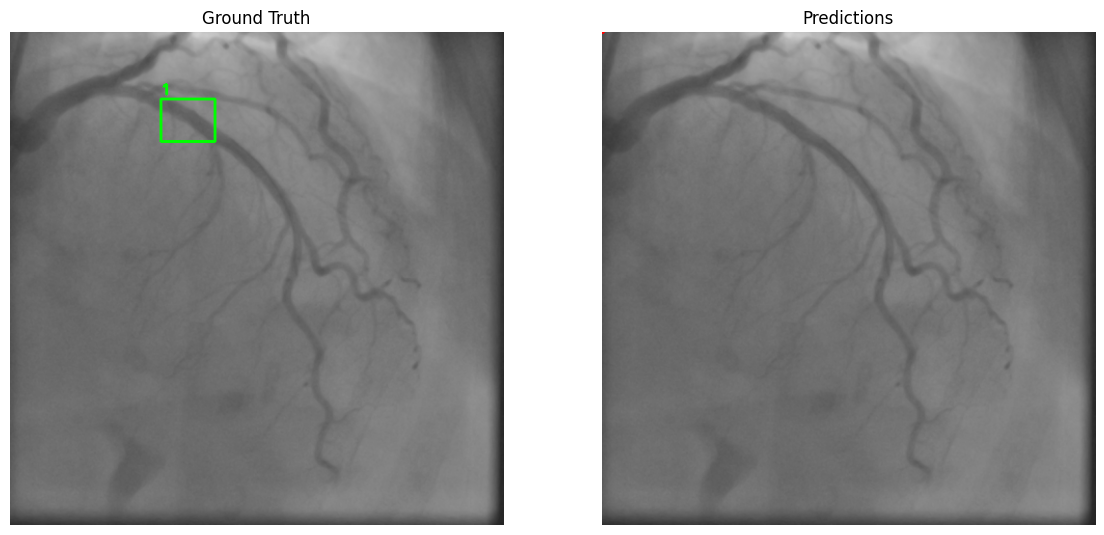

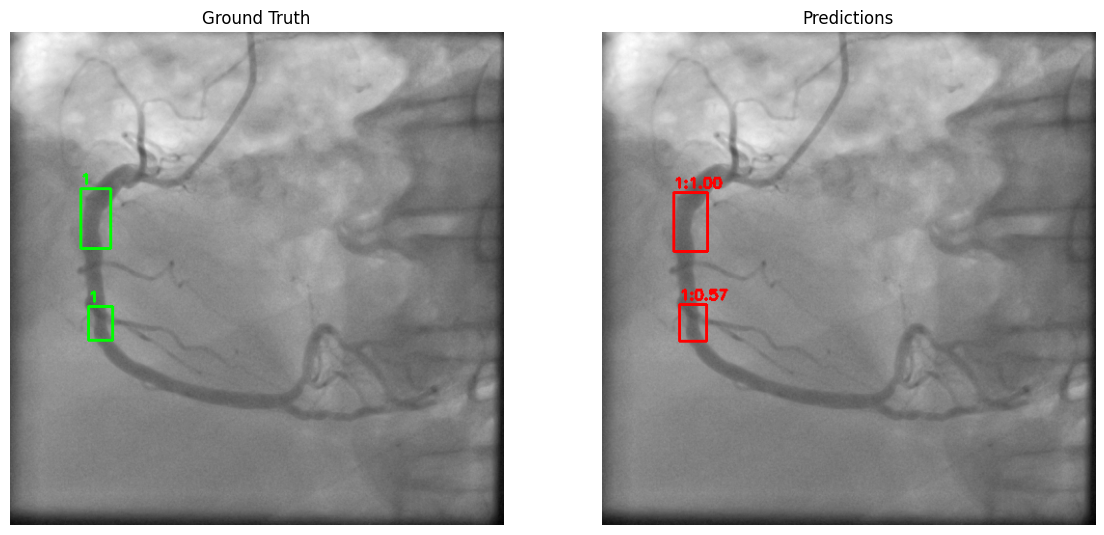

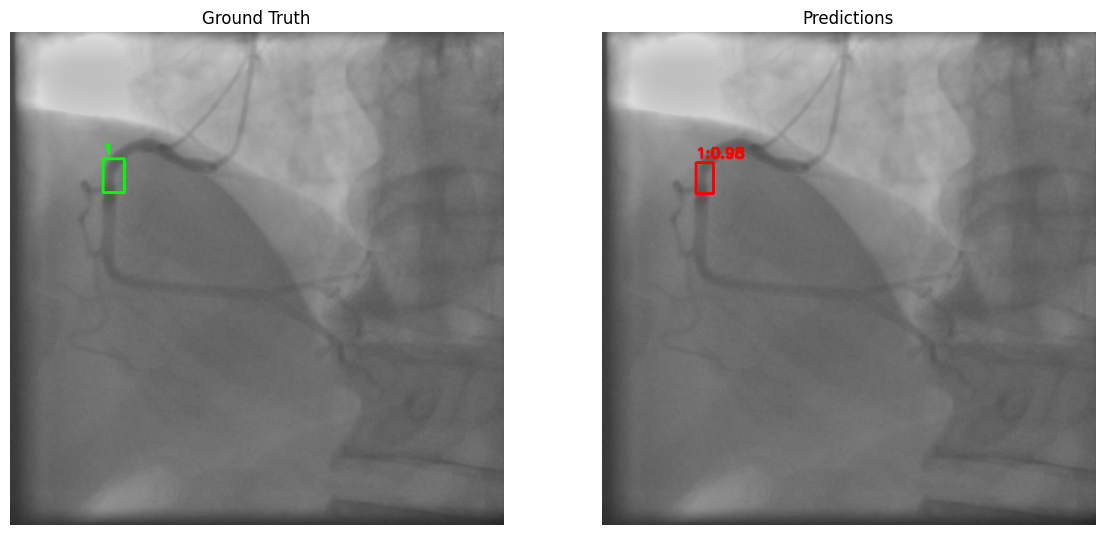

In [22]:
# Load your ground truth and prediction dataframes
gt_df = pd.read_csv('/home/tushar/test.csv')
pred_df = test_df  # from your inference step

# Directory containing your test images
image_dir = "/home/tushar/cadica/CADICA/selectedVideos"
# Visualize a few random images
import random
sample_ids = random.sample(list(gt_df['image_id'].unique()), 20)
for image_id in sample_ids:
    visualize_prediction(image_dir, image_id, gt_df, pred_df, score_thresh=0.5)

# 5 epochs

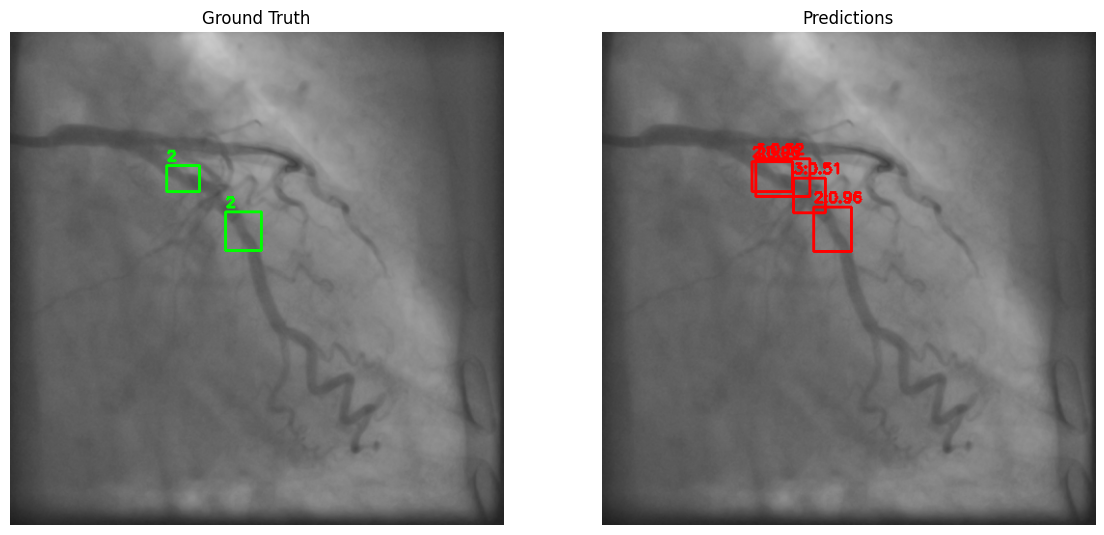

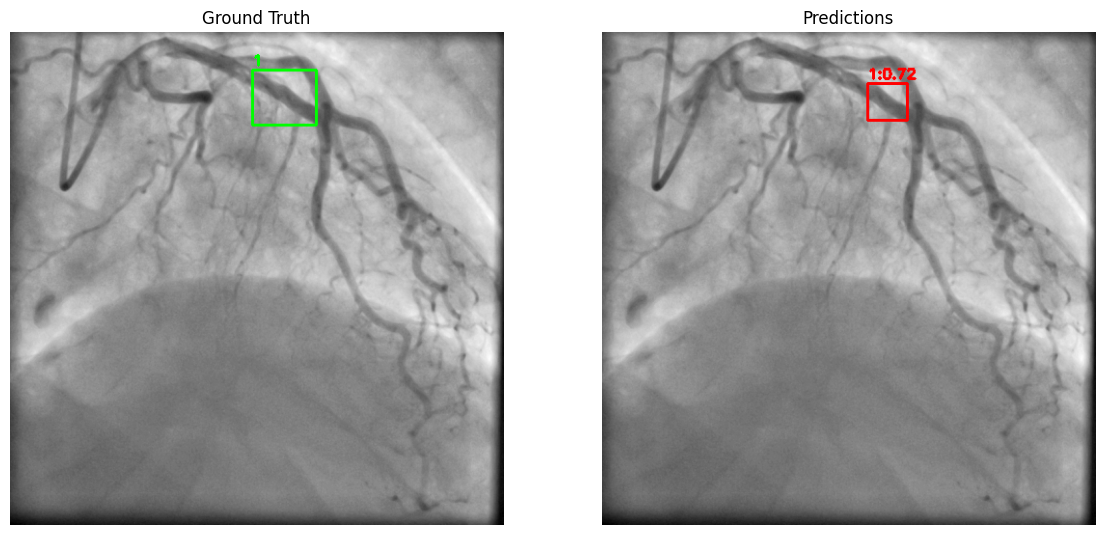

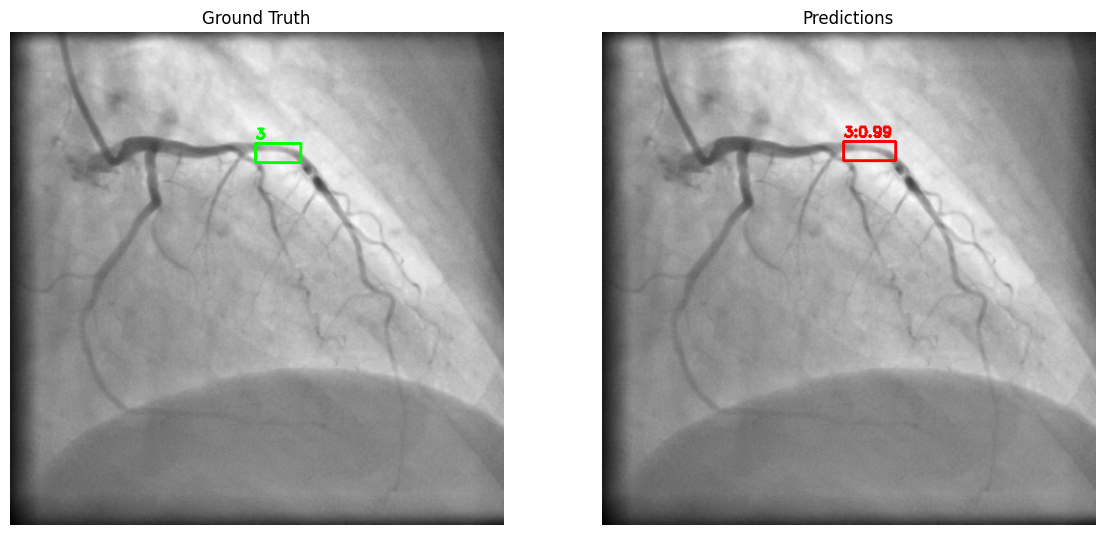

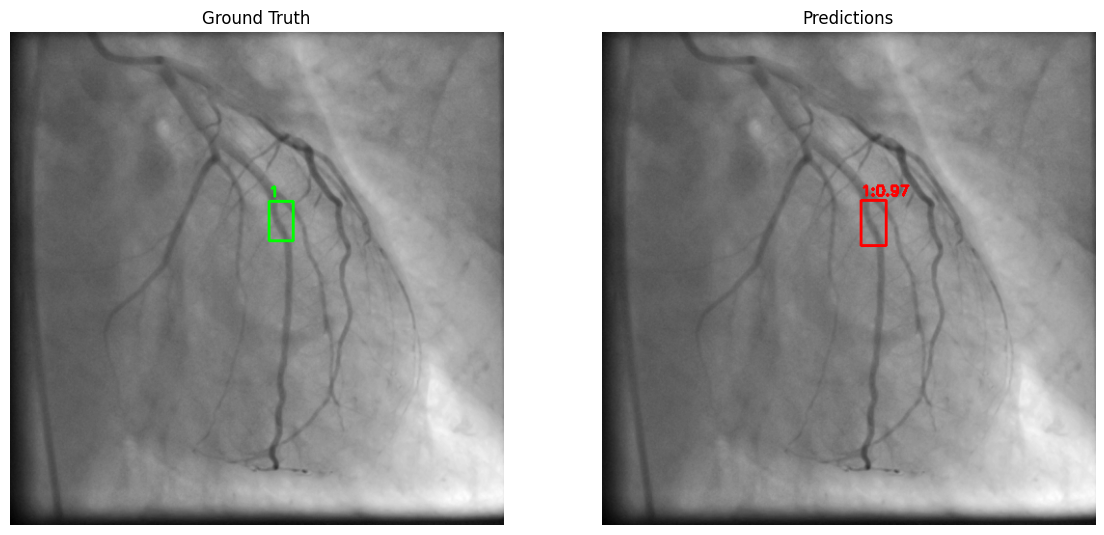

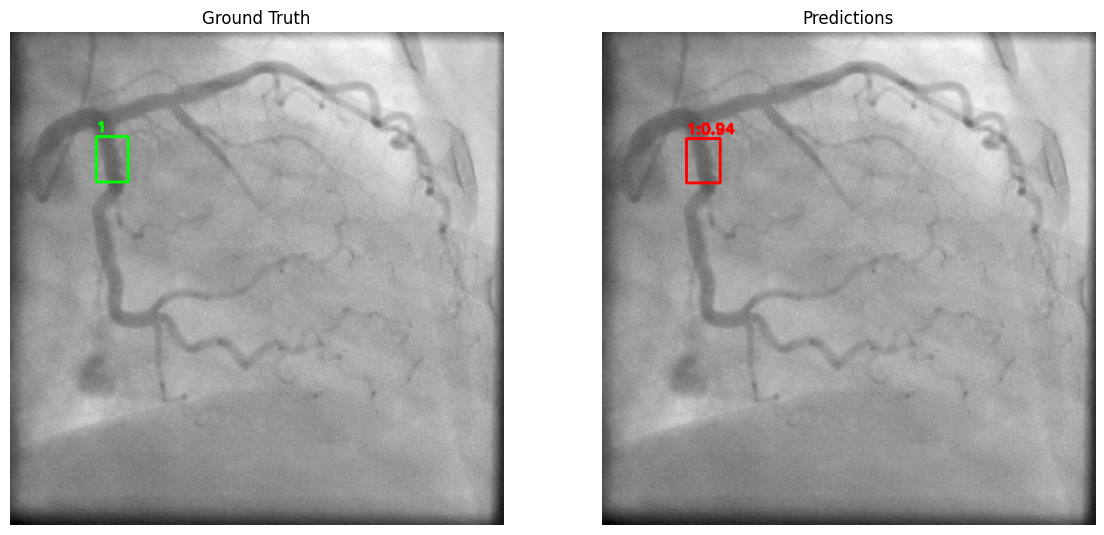

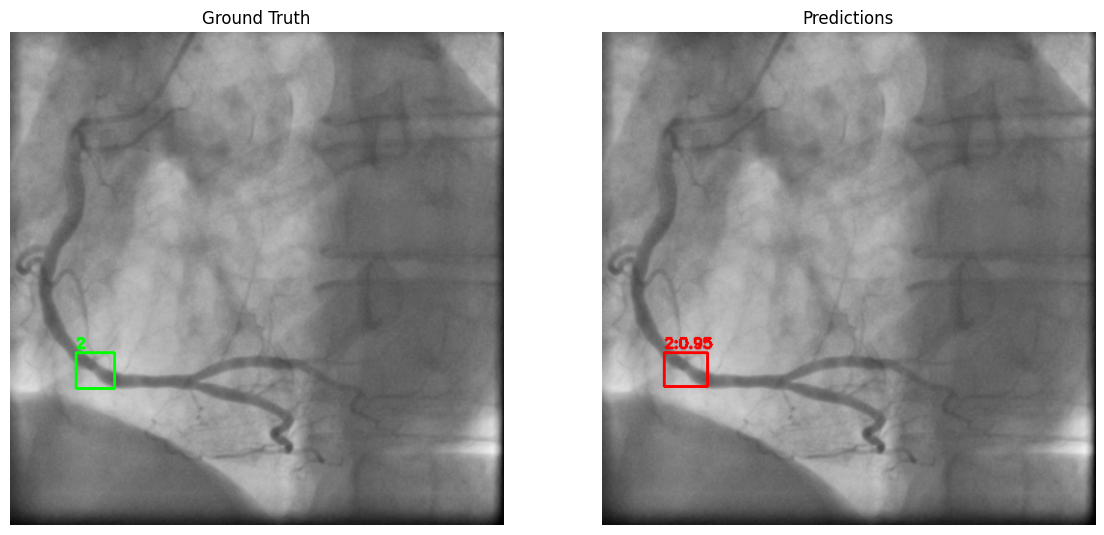

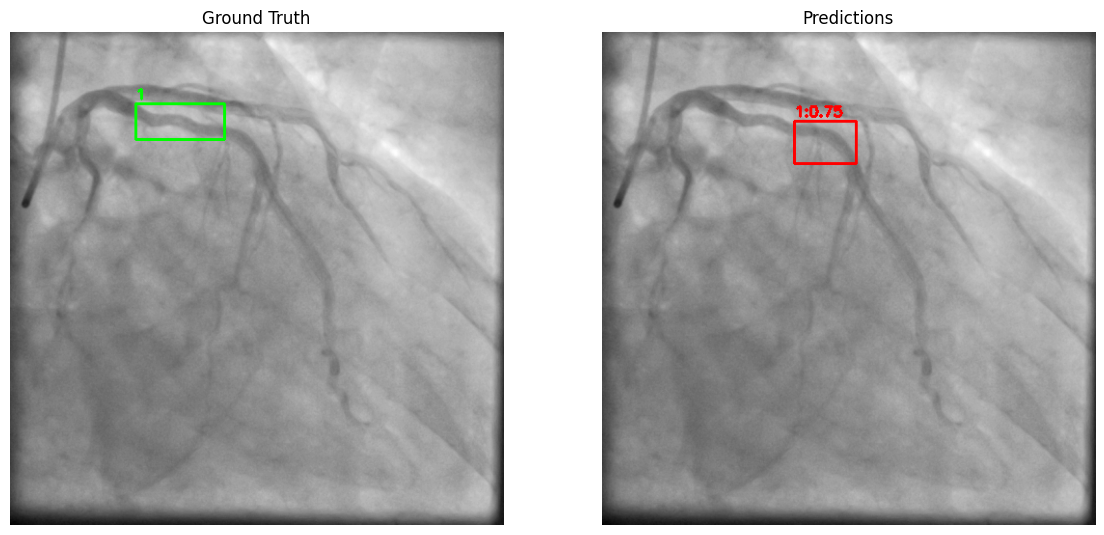

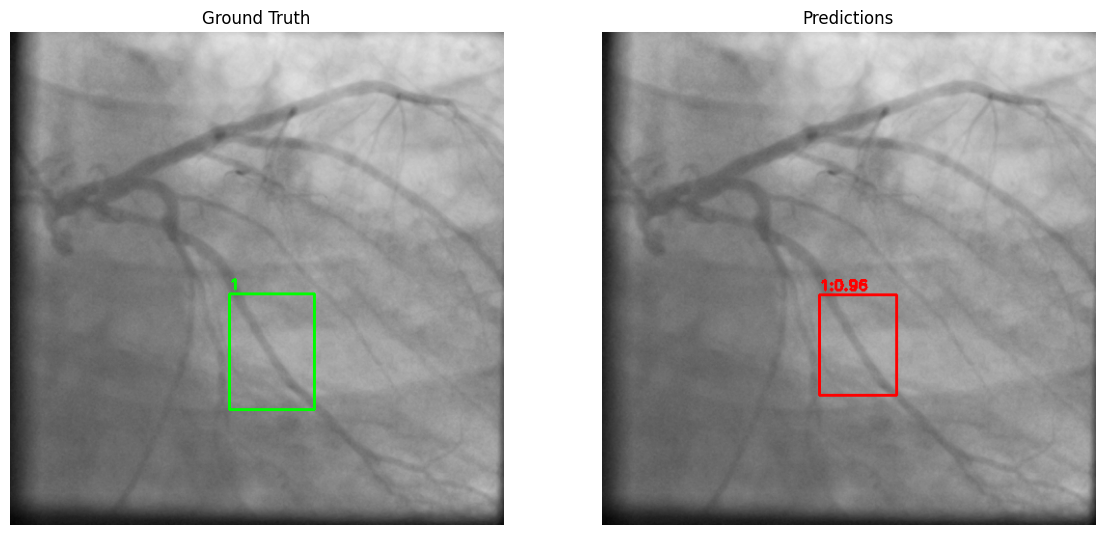

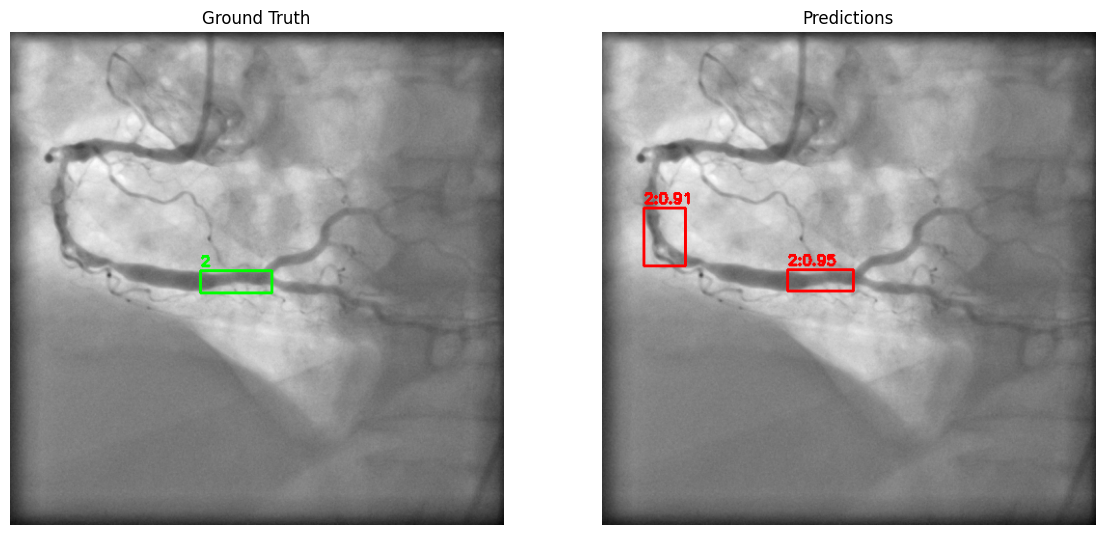

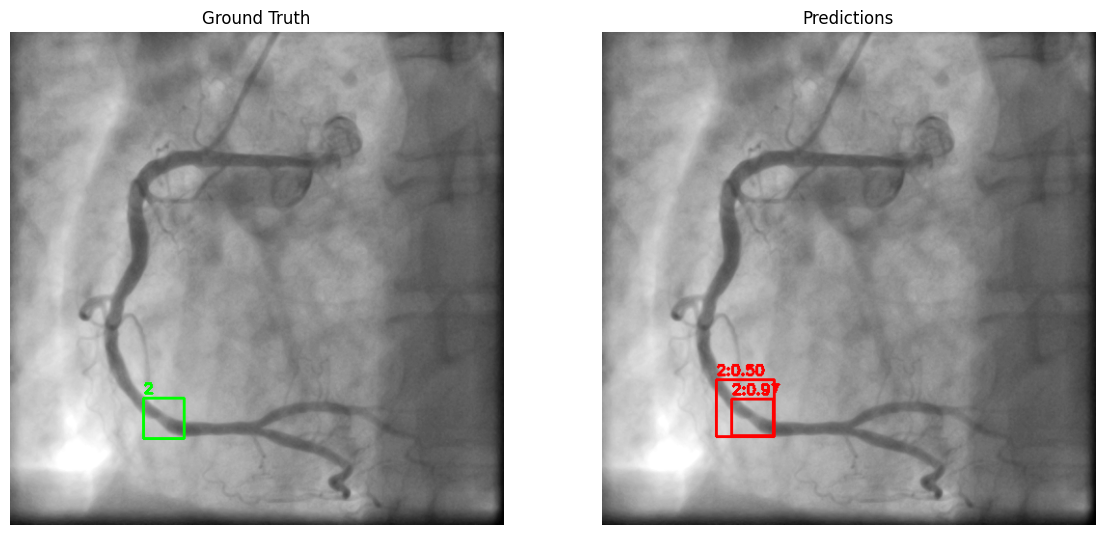

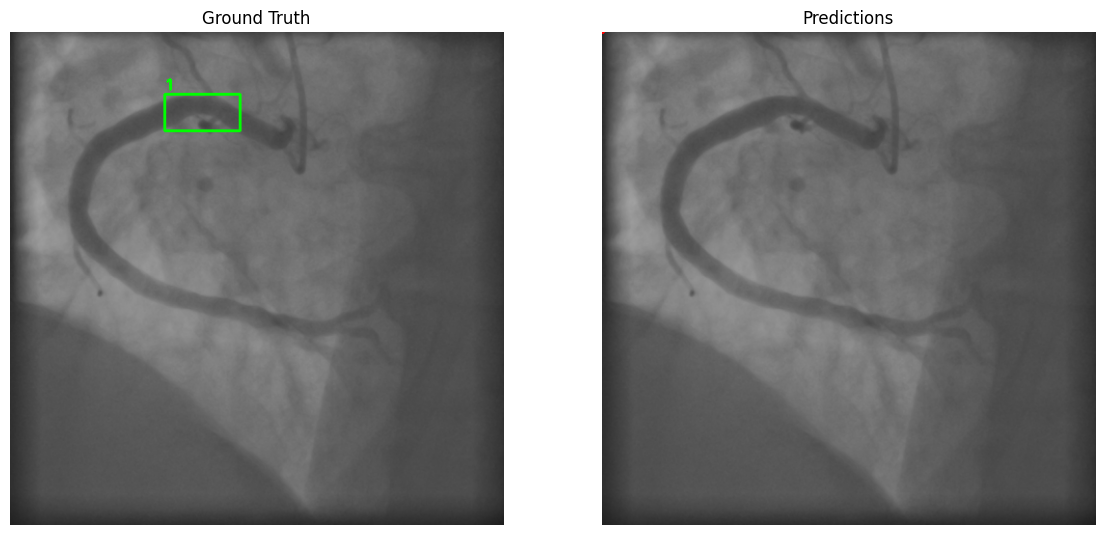

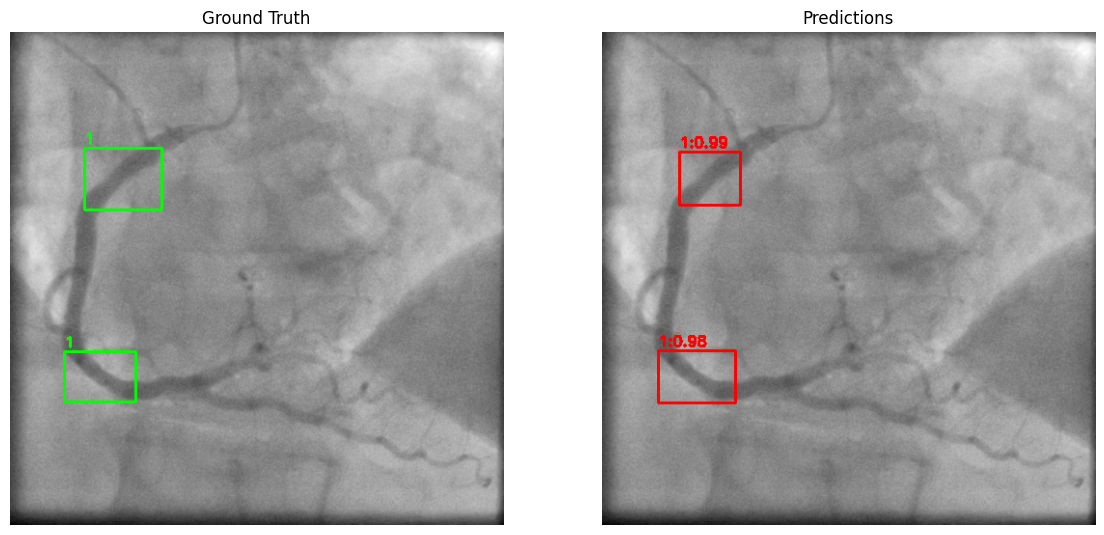

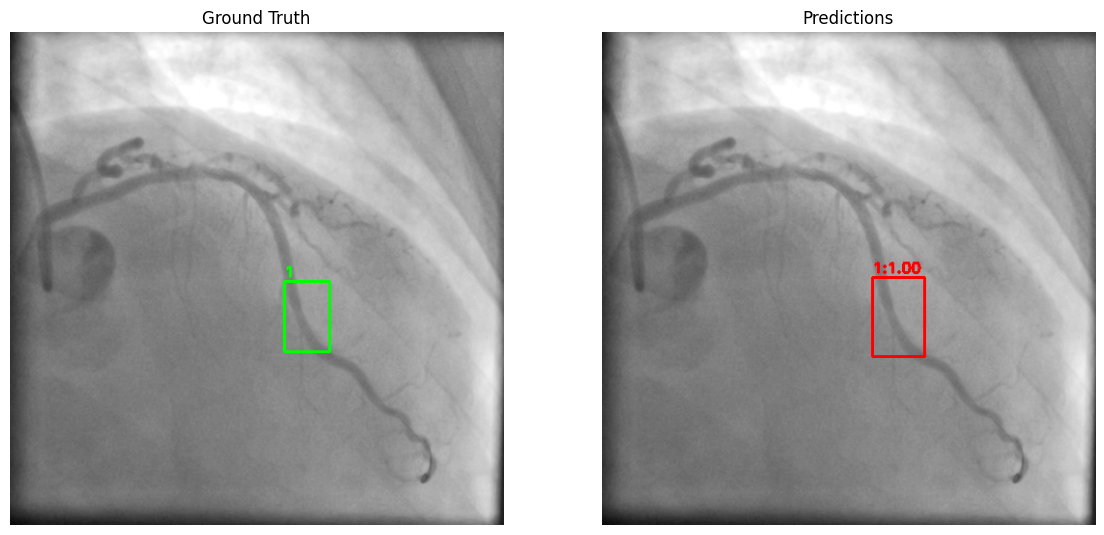

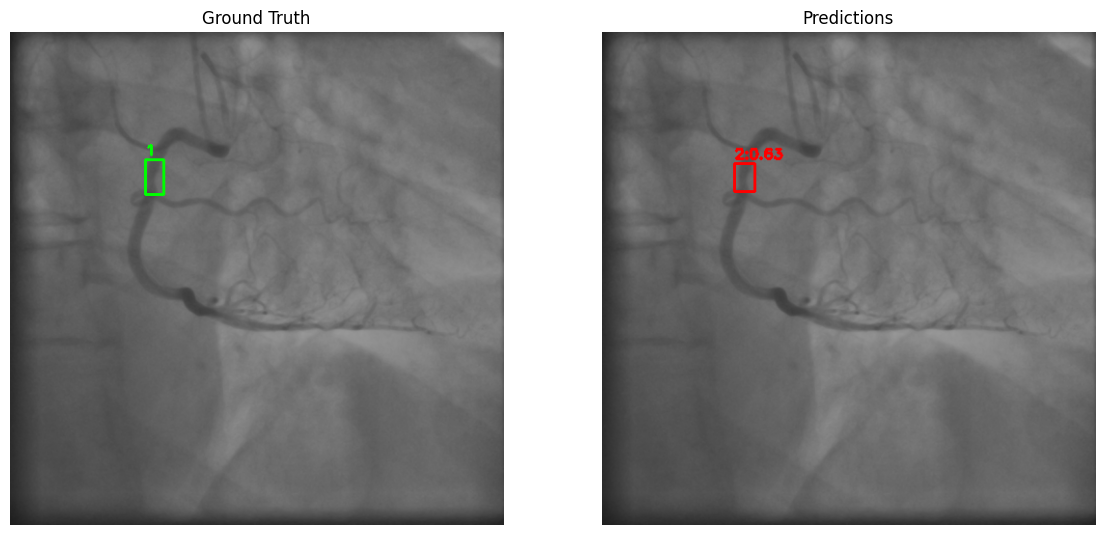

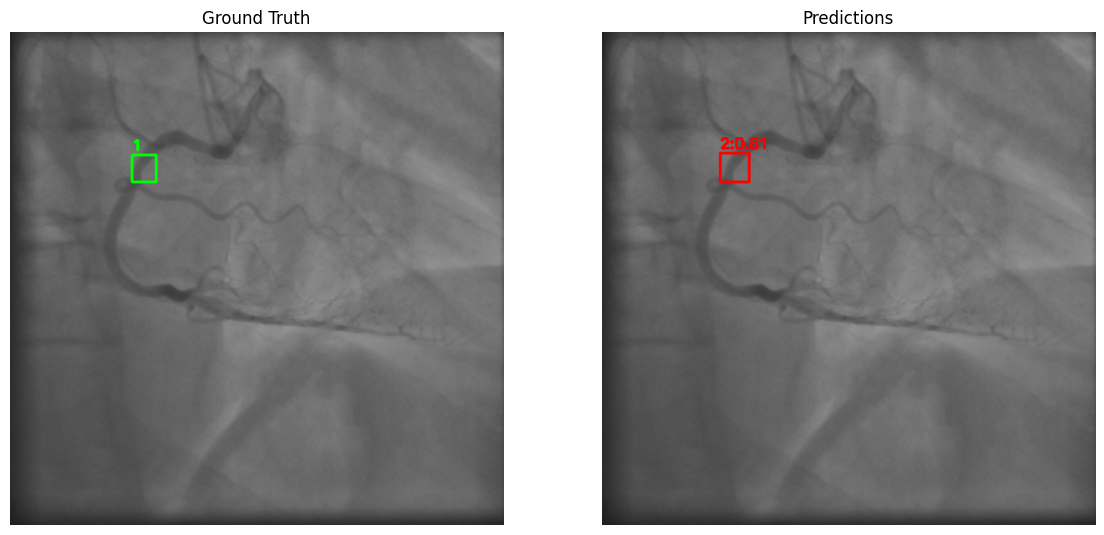

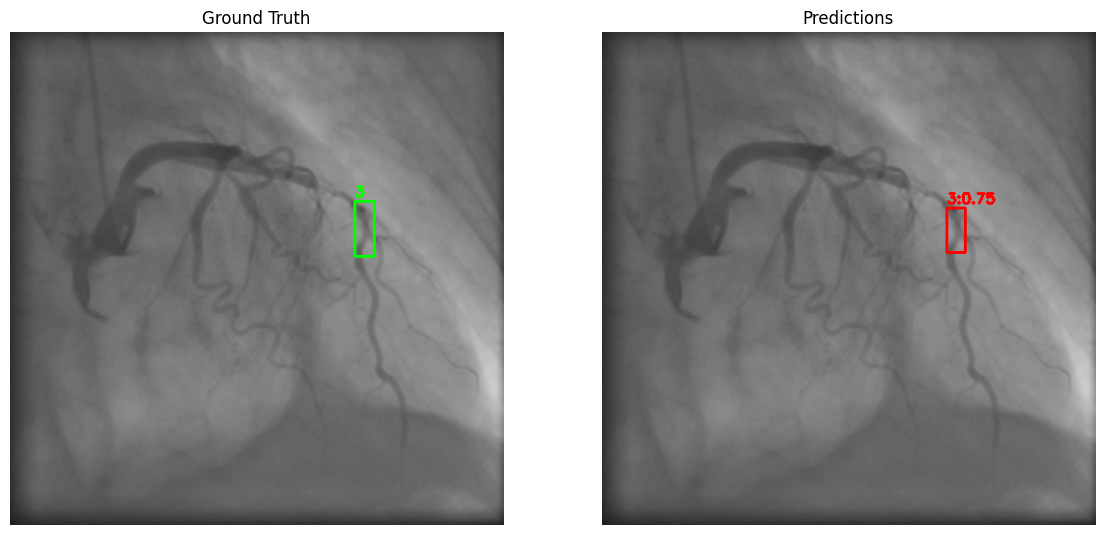

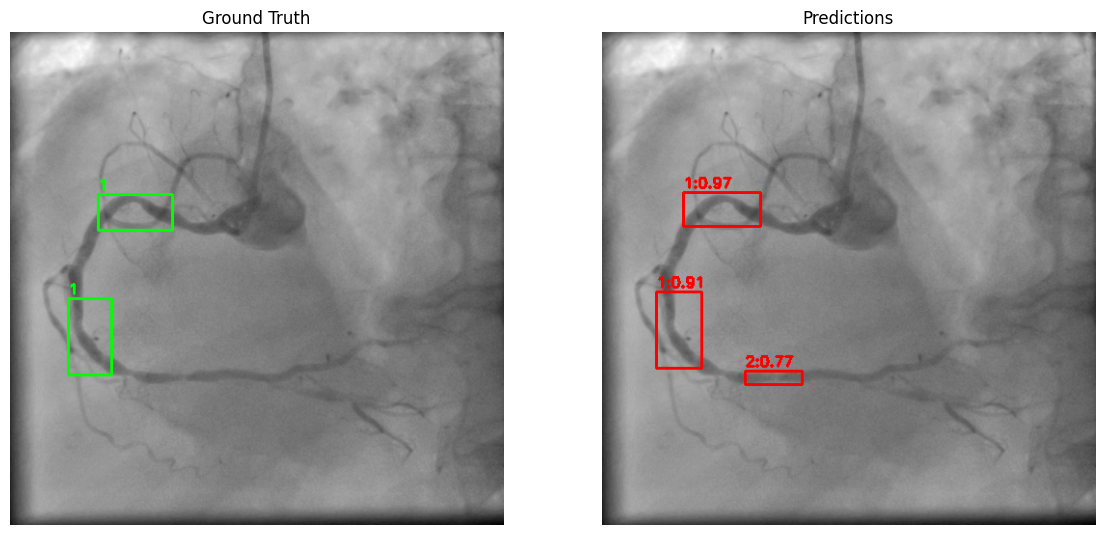

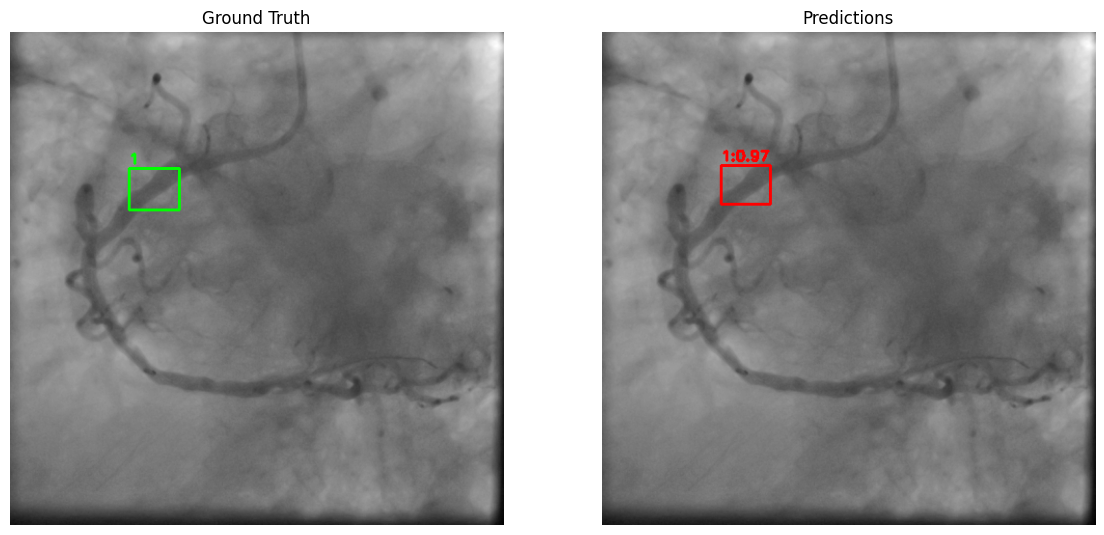

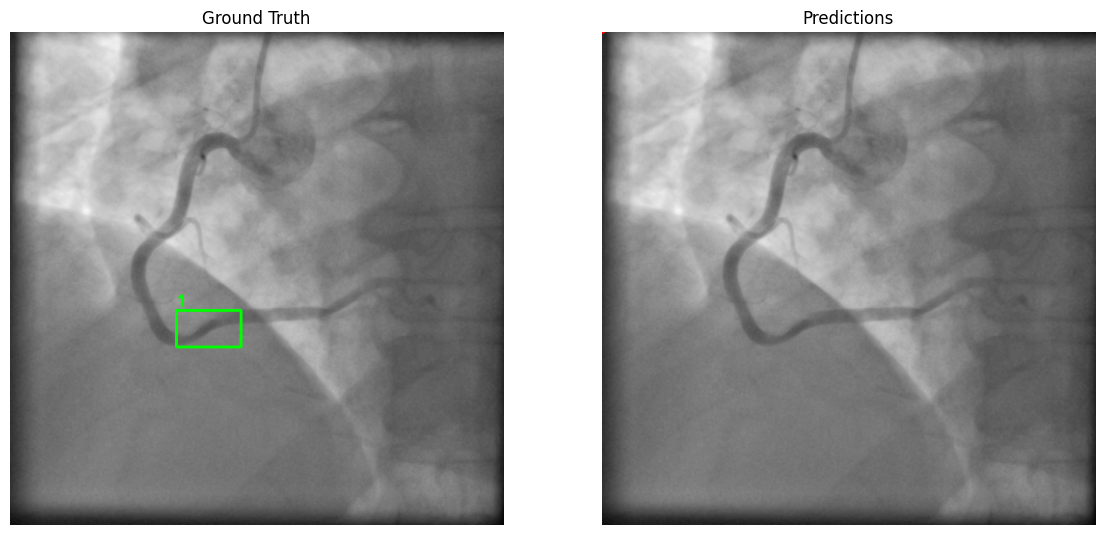

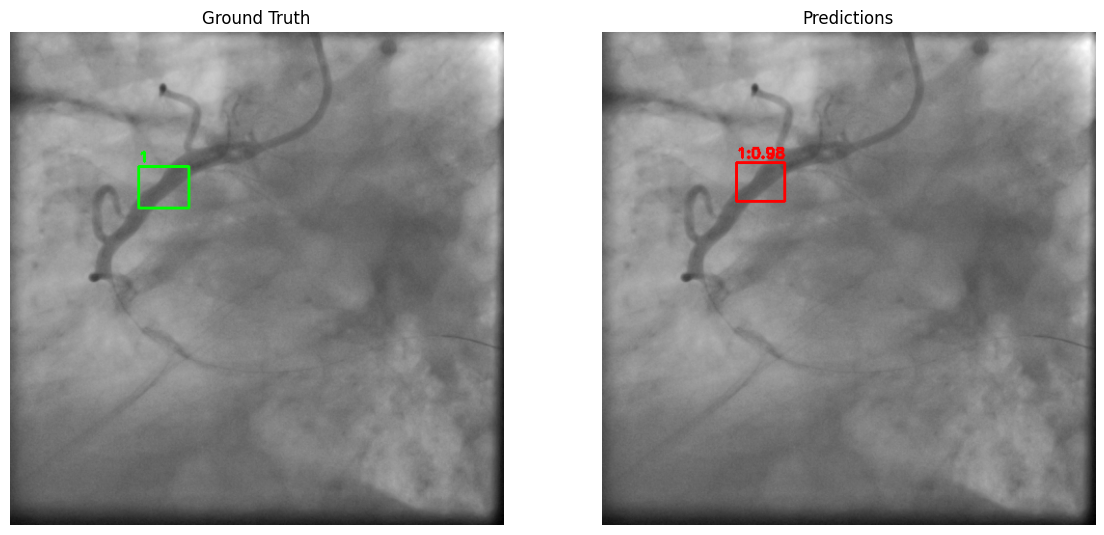

: 

In [28]:
# Load your ground truth and prediction dataframes
gt_df = pd.read_csv('/home/tushar/test.csv')
pred_df = test_df  # from your inference step

# Directory containing your test images
image_dir = "/home/tushar/cadica/CADICA/selectedVideos"
# Visualize a few random images
import random
sample_ids = random.sample(list(gt_df['image_id'].unique()), 20)
for image_id in sample_ids:
    visualize_prediction(image_dir, image_id, gt_df, pred_df, score_thresh=0.5)